In [243]:
%%capture
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in colab, downloading packages")
    !pip install -q condacolab;
    import condacolab
    condacolab.install()
    !conda install numpy scipy jupyter matplotlib mpmath setuptools setuptools_scm mock nose -y
    !conda install -c conda-forge brian2 -y
    !pip install neurodynex3
else:
    print("Not running in Google Colab")


In [244]:
#Importing libraries
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import random
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from scipy.integrate import odeint

#Numerical neurons parameters for the project
V_REST = 15 * b2.mV
V_RESET = -50 * b2.mV
MEMBRANE_RESISTANCE = 50 * b2.ohm
MEMBRANE_TIME_SCALE = 10 * b2.ms
FIRING_THRESHOLD = 0 * b2.mV
BETA = 100000 * b2.Hz


## EX 0

In [328]:
def Iext(t, I0 = 0.5 * b2.mamp, w = 100*b2.Hz, dt=b2.ms):
    return I0*(1+np.sin(w*t*dt))

def escape_function(voltage, beta=BETA, firing_threshold=FIRING_THRESHOLD) :
  return (voltage > firing_threshold)*beta

def raster_plot(ST, ax, dt=1e-2*b2.ms):
    num_time_steps, num_neurons = ST.shape

    # Create an empty figure
    # Iterate over the neurons
    for neuron_idx in range(num_neurons):
        # Get the indices where the neuron fired (value is True)
        firing_indices = np.where(ST[:,neuron_idx])[0]
        
        # Plot the firing indices against the neuron index
        ax.scatter(firing_indices*dt, np.full_like(firing_indices, neuron_idx),
                  color='black', marker='.', linewidth=1)

    # Set plot limits and labels
    ax.set_xlim([0, num_time_steps]*dt)
    ax.set_ylim([0, num_neurons])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron')

    # Show the plot
def IV_plot(Ie, Vs, t, ax,dt = 1e-2*b2.ms):
    if not(Ie is None):
      ax2 = ax.twinx()

      # Shift the position of the right axis upwards

      # Plot the second curve on the second axis
      ax2.plot(t*dt, Ie, label='$I_{ext}(t)$', c="orange")
      ax2.set_ylabel('Current [A]', color='orange')
      ax2.tick_params('y', colors='orange')
      ax2.set_ylim([np.min(Vs[:, 0])-10*b2.mV, np.max(Ie)+10*b2.mV])

    ax.set_ylim([np.min(Vs[:, 0])-10*b2.mV, np.max(Ie)+10*b2.mV])
    ax.plot(t*dt, Vs[:, 0], label='$V_1(t)$')
    ax.set_xlabel(f'Time [s]')
    ax.set_ylabel('Voltage(V)')
    ax.grid()
    ax.legend()
    ax2.legend(loc='lower right')
    
def activity_plot(ST, t, ax, tA=1*b2.ms,dt = 1e-2*b2.ms,N=100):
    At = np.array([np.sum(s)/N for s in ST])/dt
    At = np.convolve(At, np.ones_like(np.linspace(-tA/2, tA/2, int(tA/dt)))/ tA*dt, mode='same')
    ax.plot(t*dt, At, label='A(t)')
    ax.set_xlabel(f'Time [s]')
    ax.set_ylabel('Activity(Hz)')
    ax.grid()
    ax.legend()


In [250]:
                
def non_interacting(vi, T=100*b2.ms,dt=b2.ms):
    steps = int(T/dt)+1 
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))*b2.mV

    voltages[0] = 1e3*b2.mV*vi
    # Set the initial condition and time points
    for i in range(0,steps-1):
        voltages[i+1] = voltages[i]+dt/MEMBRANE_TIME_SCALE*((-voltages[i]+V_REST)+MEMBRANE_RESISTANCE*Iext(i,dt=dt))
        firing = escape_function(voltages[i])*dt
        voltages[i+1]+=(V_RESET-voltages[i+1])*firing
        spike_train[i]=firing

    return voltages, spike_train

In [251]:
N = 100
dt = 1e-2*b2.ms
Vi0 = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)
Vs0, ST0 = non_interacting(Vi0, dt=dt, T=100*b2.ms)


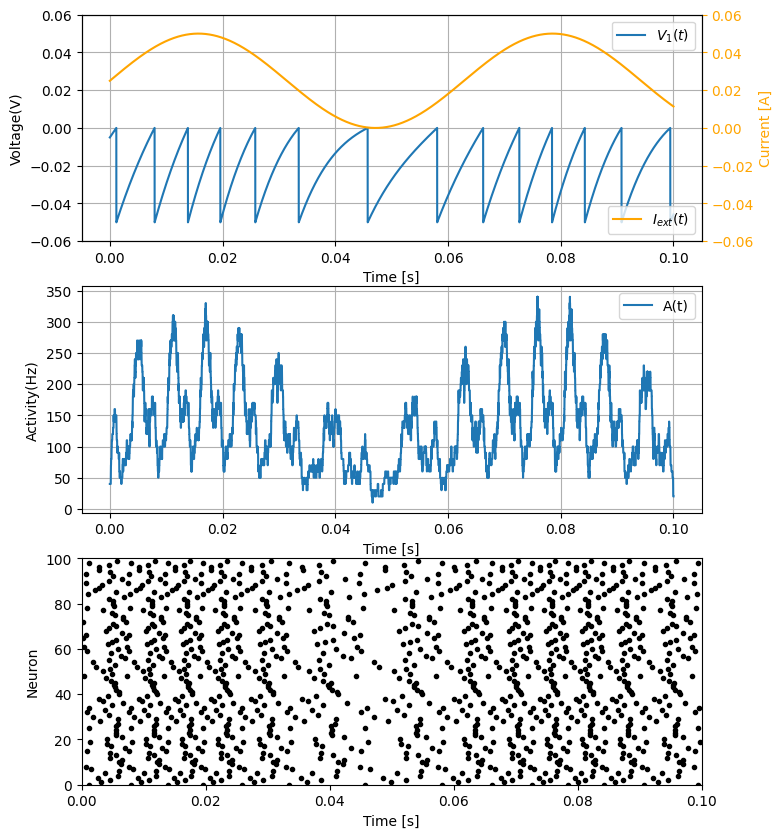

In [252]:
steps = Vs0.shape[0]
t = np.arange(0, steps, 1)
Ie0 = Iext(t, dt=dt)*MEMBRANE_RESISTANCE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(Ie0, Vs0,t, ax1)
activity_plot(ST0,t,ax2)
raster_plot(ST0, ax3)

# Answer question exo-0-q2
The behavior of the system do not change from the beginning, the voltage periodically follows the sinusoidal input current.

# Exercice 1
## Question 1

In [331]:
tepsilon = 2*b2.ms
J = 20*b2.mV
delta = 5*b2.ms
                
def synchronous_state(vi, I, T=600*b2.ms,dt=b2.ms, beta=BETA):
    steps = int(T/dt)+1    
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))*b2.mV
    voltages[0] = vi*1e3*b2.mV
    epsilonA = np.zeros(steps)*b2.Hz
    epsilonB = np.zeros(steps)*b2.Hz
    for i in range(0,steps-1):

      voltages[i+1]= voltages[i]+dt*(-(voltages[i]-V_REST-MEMBRANE_RESISTANCE*I[i])+MEMBRANE_TIME_SCALE*J*epsilonA[i-int(delta/dt)]) / MEMBRANE_TIME_SCALE
      firing = escape_function(voltages[i], beta=BETA)*dt
      voltages[i+1]+=(V_RESET-voltages[i+1])*firing
      spike_train[i]=firing
      if i*dt > delta:
        epsilonB[i+1] = (-dt*(epsilonB[i])+np.mean(spike_train[i])) /tepsilon +epsilonB[i]
        epsilonA[i+1] = dt*(-epsilonA[i]+epsilonB[i]) / tepsilon +epsilonA[i]
    return voltages, spike_train

In [329]:
N = 100
dt = 1e-2*b2.ms
Vi = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)

In [284]:
T=600*b2.ms
Vs1, ST1 = synchronous_state(Vi, dt=dt, T=T, I=np.zeros(int(T/dt))*1e3*b2.mA)

In [78]:
"""steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(None, Vs1,t, ax1)
activity_plot(ST1,t,ax2)
raster_plot(ST1, ax3)"""

'steps = Vs1.shape[0]\nt = np.arange(0, steps, 1)\n\nfig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))\nIV_plot(None, Vs1,t, ax1)\nactivity_plot(ST1,t,ax2)\nraster_plot(ST1, ax3)'

## Question 2

In [285]:
i30=np.round(30*b2.ms/dt).astype(int)
i200=np.round(200*b2.ms/dt).astype(int)

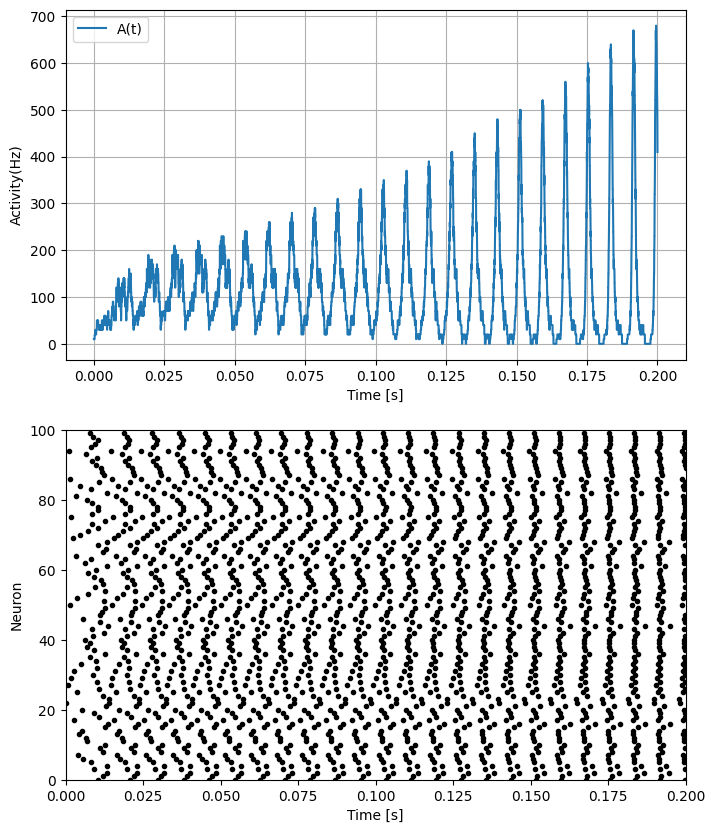

In [286]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST1[0:i200,:],t[0:i200],ax1)
raster_plot(ST1[0:i200,:], ax2)

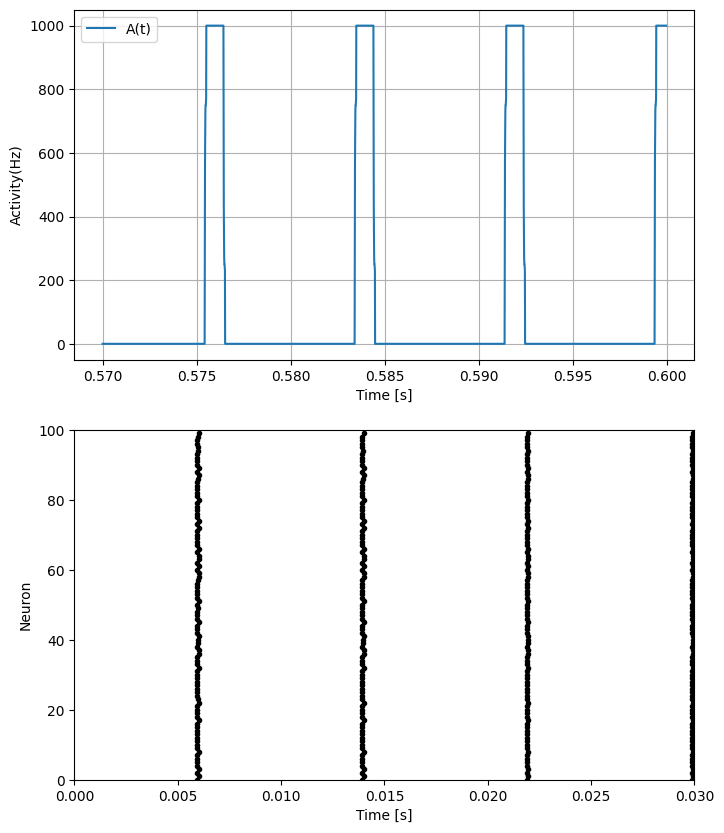

In [257]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST1[-1-i30:-1],t[-1-i30:-1],ax1)
raster_plot(ST1[-1-i30:-1], ax2)

In [268]:
period = np.mean([np.diff(np.nonzero(s)) for s in ST1[-1-i30:-1].T])*dt
print(f"The period is {period*1e3} ms")

The period is 7.980000000000001 ms


## Question 3

In [327]:
dt = 1e-2*b2.ms
T=600*b2.ms
Vs2, ST2 = synchronous_state(Vi, dt=dt, T=T, I=np.full(int(T/dt), -0.25*b2.mA)*1e3*b2.mA)

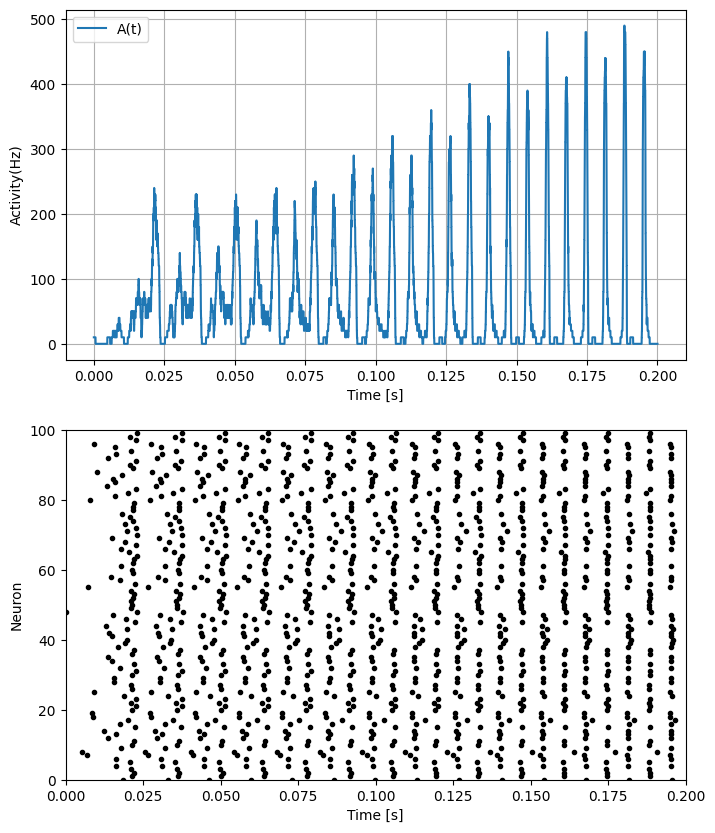

In [287]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST2[0:i200,:],t[0:i200],ax1)
raster_plot(ST2[0:i200,:], ax2)

In [271]:
1/0.007

142.85714285714286

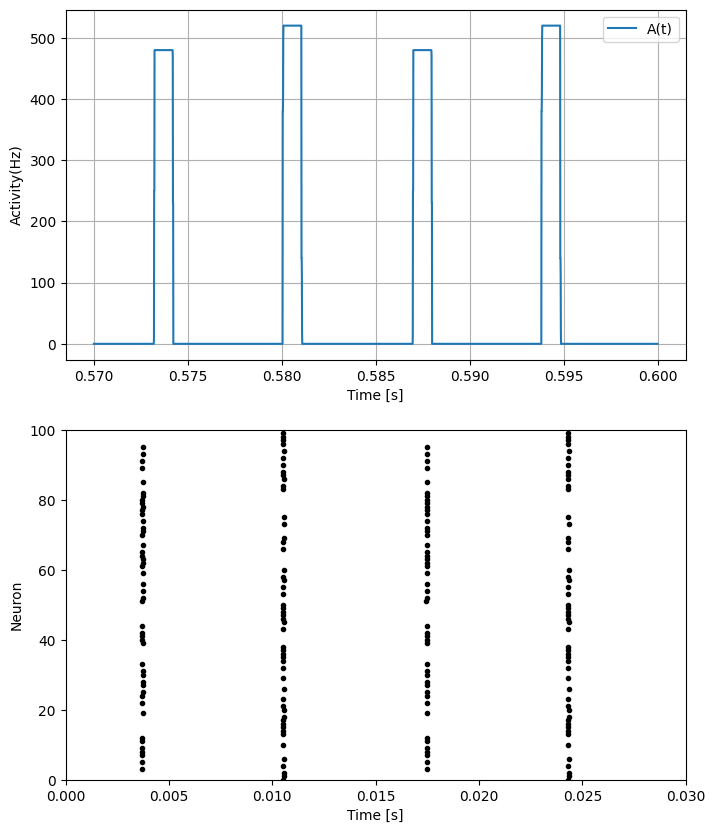

In [263]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST2[-1-i30:-1],t[-1-i30:-1],ax1)
raster_plot(ST2[-1-i30:-1], ax2)

# Exo 2

In [264]:
def intervals_spike(ST):
  tn1 = np.nonzero(ST[:,0])[0]
  # Iterating through the firing times of neuron 1
  rtimes = []
  intervals = []
  for i in range(len(tn1)-1):
    Imax = tn1[i+1]
    Imin = tn1[i]
    intervals.append(Imax-Imin)
    t = []
    # Iterating through the neurons
    for n in range(1, ST.shape[1]):
      indices = np.nonzero(ST[:,n])[0]
      t.append(indices[(indices>Imin)*(indices<=Imax)][0])
    rtimes.append(t-Imin)

  return np.array(rtimes)*dt, intervals*dt



In [265]:
# rtimes, intervals = intervals_spike(ST0)
# for n in range(rtimes.shape[1]):
#   plt.scatter(range(rtimes.shape[0]), rtimes[:,n], s=1)
# plt.scatter(range(len(intervals)), intervals, marker="x", s=20, c="black", label = "Intervals")
# plt.legend()

In [269]:
period = np.mean([np.diff(np.nonzero(s)) for s in ST2[-1-i30:-1].T])*dt
print(f"The period is {period*1e3} ms")

The period is 13.770000000000001 ms


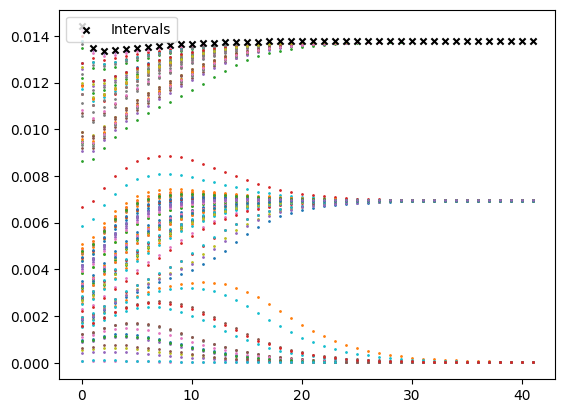

In [267]:
rtimes, intervals = intervals_spike(ST2)
for n in range(rtimes.shape[1]):
  plt.scatter(np.cumsum(intervals), rtimes[:,n], s=1)
plt.scatter(np.cumsum(intervals), intervals, marker="x", s=20, c="black", label = "Intervals")
plt.legend()

Faire relation entre activity plot et ce plot
--> plusieurs groupes, difference de frequence facteur 2 --> amplitude qui varie

In [323]:
T=1e3*b2.ms
I0 = -0.25*b2.mA
steps = np.arange(0,int(T/dt)+1, 1)*dt
I = I0*(steps>500*b2.ms)
Vs3, ST3 = synchronous_state(Vi, dt=dt, T=T, I=I)

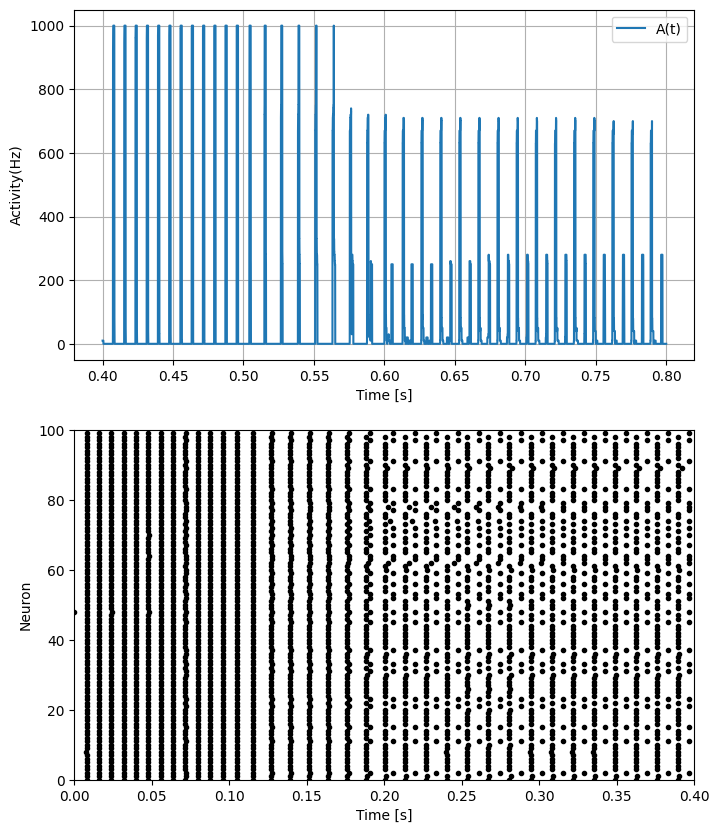

In [324]:
steps = Vs3.shape[0]
t = np.arange(0, steps, 1)
i400=np.round(400*b2.ms/dt).astype(int)
i800=np.round(800*b2.ms/dt).astype(int)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST3[i400:i800,:],t[i400:i800],ax1)
raster_plot(ST3[i400:i800,:], ax2)

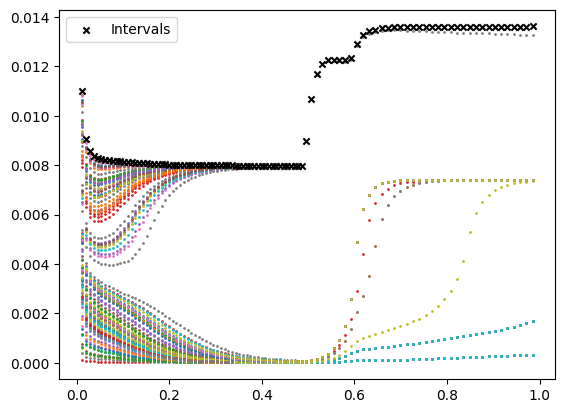

In [344]:
rtimes, intervals = intervals_spike(ST3)
for n in range(rtimes.shape[1]):
  plt.scatter(np.cumsum(intervals), rtimes[:,n], s=1)
plt.scatter(np.cumsum(intervals), intervals, marker="x", s=20, c="black", label = "Intervals")
plt.legend()

In [326]:
BETA2 = 0.025*b2.Hz

In [346]:
T=2e3*b2.ms
I0 = -0.25*b2.mA
steps = np.arange(0,int(T/dt)+1, 1)*dt
I = I0*steps/T
Vs4, ST4 = synchronous_state(Vi, dt=dt, T=T, I=I, beta=BETA2)

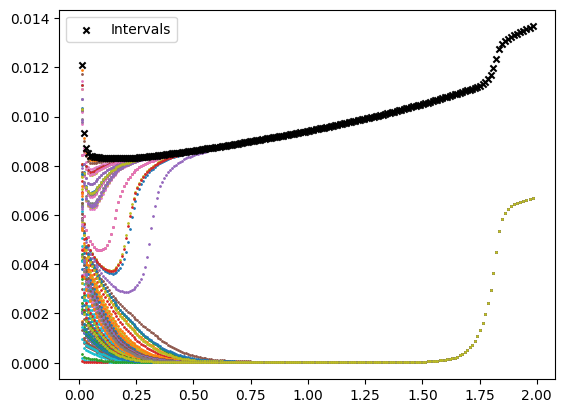

In [347]:

rtimes, intervals = intervals_spike(ST4)
for n in range(rtimes.shape[1]):
  plt.scatter(np.cumsum(intervals), rtimes[:,n], s=1)
plt.scatter(np.cumsum(intervals), intervals, marker="x", s=20, c="black", label = "Intervals")
plt.legend()